In [1]:
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json
import os
import re
import pprint

basepath = Path(os.getcwd())
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
    print(os.getcwd())
load_dotenv(find_dotenv())

%load_ext autoreload
%autoreload 2

/srv/idp-radio-1


In [ ]:
data = json.loads(os.environ['EXP_DATA'])
history = data['history']

# Model and Benchmark Summary

In [ ]:
for s in data["description"].split(".")[:-1]:
    print(s + ".\n")

## Extract and format metrics to be plotted

In [ ]:
# if there are any metrics that were renamed, add this new name here as ("default_name":"new_name")
metric_custom_names={"auc":"AUC_ROC"}

metric_names = [re.sub("([a-z0-9])([A-Z])","\g<1> \g<2>",name) for name in data["benchmark"]["metrics"]]
metric_keys = [re.sub("([a-z0-9])([A-Z])","\g<1>_\g<2>",name).lower() for name in data["benchmark"]["metrics"]]

for default_name, custom_name in metric_custom_names.items():
    if not default_name in history.keys() and default_name in metric_keys:
        #replace default name with custom name
        metric_keys[metric_keys.index(default_name)]=custom_name


In [ ]:
def print_or_plot_metric(metric_key, metric_name, figure_name):
    if len(history[metric_key]) == 1:
        print("Data for {m_name} only available for a single epoch. \nSkipping plot and printing data...".format(m_name=metric_name))
        print('Train {}: '.format(metric_name), history[metric_key])
        print('Validation {}: '.format(metric_name), history['val_'+metric_key])
        print()        
    else:
        plot_epoch_metric(metric_key, metric_name, figure_name)
        
def plot_epoch_metric(metric_key, metric_name, figure_name):
    figure(num=None, figsize=(10, 6))
    plt.plot(history[metric_key])
    if 'val_'+metric_key in history.keys():
        plt.plot(history['val_'+metric_key])
    plt.title(figure_name)
    plt.ylabel(metric_name)
    plt.xlabel('Epoch')
    if 'val_'+metric_key in history.keys():
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


## Plot training & validation loss values

In [ ]:
print_or_plot_metric("loss", "Loss", "Model loss")

In [ ]:
if "lr" in history.keys():
    plot_epoch_metric("lr", "Learning Rate", "Learning Rate")

## Validation Scores

In [ ]:
for name, scores in history.items():
    if "val_" in name:
        print('Valid {}: '.format(name.replace("val_", "")), scores[-1])

## Test Scores

In [ ]:
if 'test' in data.keys() and data['test']:
    for score_name, score in data["test"].items():
        print('Test {}: '.format(score_name), score)


## Classification Report

In [ ]:
if 'classification_report' in data.keys() and data['classification_report']:
    print(data['classification_report'])

## Benchmark Details

In [ ]:
pp = pprint.PrettyPrinter(indent=4)
if "benchmark" in data.keys():
    pp.pprint(data["benchmark"])

# Data Distribution

In [9]:
from src.architectures.benchmarks.benchmark_definitions import benchmark_from_logs

def get_distribution(labels):
    labels_df = pd.DataFrame(labels, columns=benchmark.label_columns)


    d = {'Pathology': [], 'Positive': [], 'Positive %': [], 'Negative': [], 'Negative %': [],}
    for label in labels_df.columns:
        values = labels_df.groupby(label)
        d['Pathology'].append(label)

        positive = values.size()[1.0] if 1.0 in values.size() else 0
        positive_percent = positive / labels_df.shape[0] * 100
        d['Positive'].append(positive)
        d['Positive %'].append(round(positive_percent, 2))

        negative = values.size()[-0.0] if -0.0 in values.size() else 0
        negative_percent = negative / labels_df.shape[0] * 100
        d['Negative'].append(negative)
        d['Negative %'].append(round(negative_percent, 2))
    
    df = pd.DataFrame(d)
    df = df.set_index('Pathology')

    return df

In [10]:
if 'benchmark' in data.keys() and 'split_seed' in data['benchmark']:
    benchmark = benchmark_from_logs(data["benchmark"])

    train_labels = benchmark.traingen.get_labels()
    valid_labels = benchmark.valgen.get_labels()
    test_labels = benchmark.testgen.get_labels()

    print("Number train samples:", len(train_labels))
    print("Number valid samples:", len(valid_labels))
    print("Number test samples:", len(test_labels))

Initialzed custom_binary_crossentropy with epsilon 1e-05
Number train samples: 211818
Number valid samples: 11596
Number test samples: 234


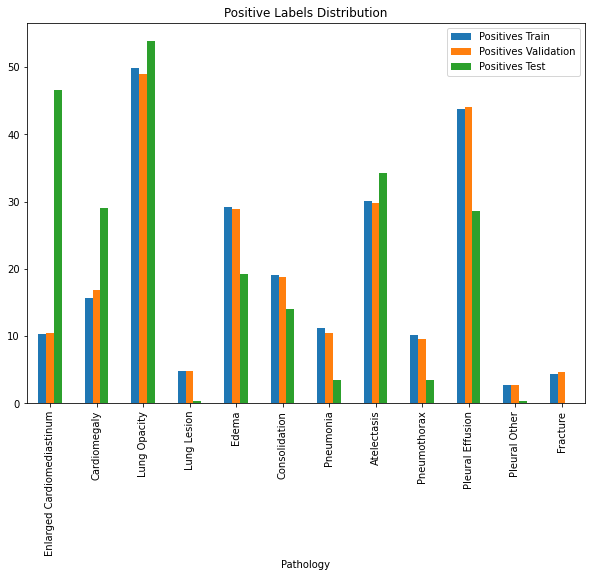

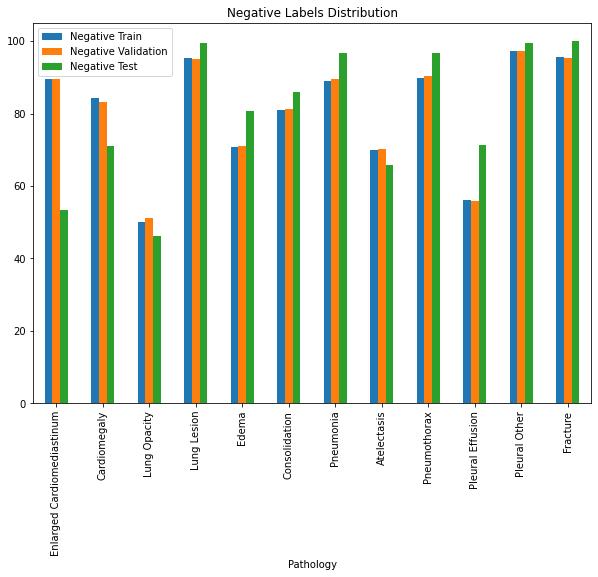

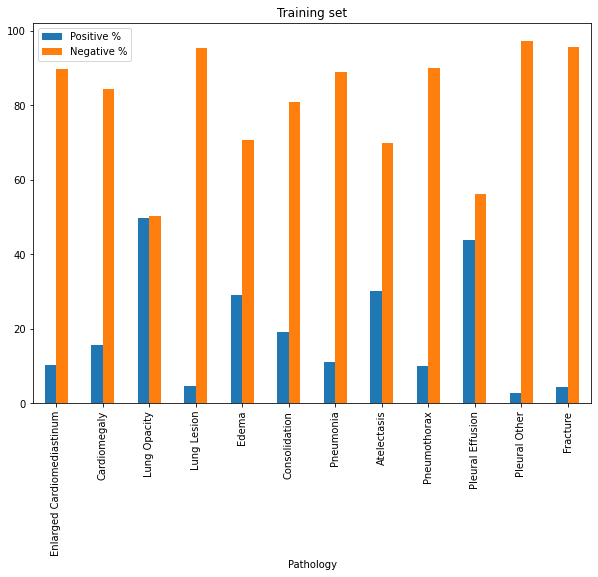

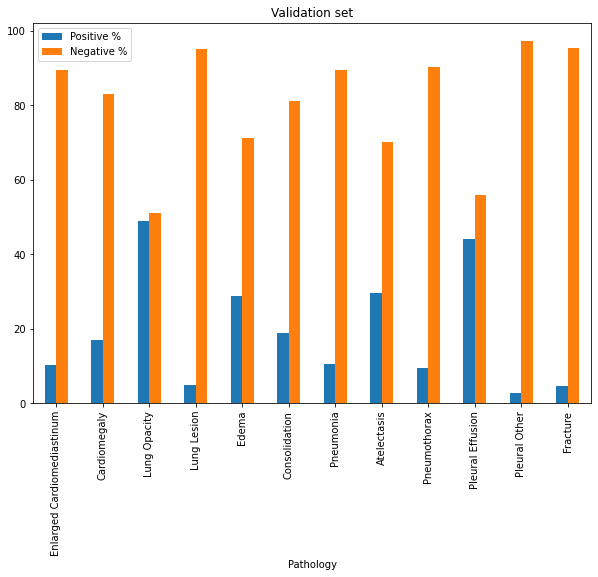

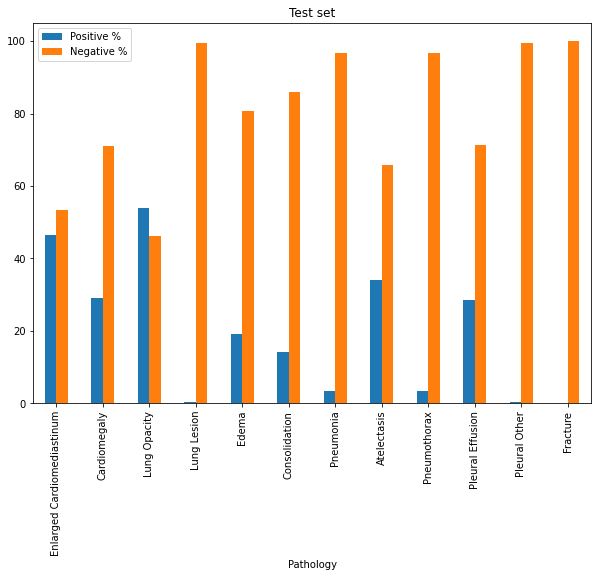

In [11]:
if 'benchmark' in data.keys() and 'split_seed' in data['benchmark']:
    train = get_distribution(train_labels)
    val = get_distribution(valid_labels)
    test = get_distribution(test_labels)

    positives = train[['Positive %']].merge(val[['Positive %']], left_index=True, right_index=True).merge(test[['Positive %']], left_index=True,  right_index=True).rename(columns={"Positive %_x": "Positives Train", "Positive %_y": "Positives Validation", "Positive %": "Positives Test", })
    positives.copy().plot(kind='bar', figsize=(10,7), title="Positive Labels Distribution")

    negatives = train[['Negative %']].merge(val[['Negative %']], left_index=True, right_index=True).merge(test[['Negative %']], left_index=True,  right_index=True).rename(columns={"Negative %_x": "Negative Train", "Negative %_y": "Negative Validation", "Negative %": "Negative Test", })
    negatives.copy().plot(kind='bar', figsize=(10,7), title="Negative Labels Distribution")

    train[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Training set")
    val[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Validation set")
    test[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Test set")

In [13]:
train

,Positive,Positive %,Negative,Negative %
Pathology,,,,
Enlarged Cardiomediastinum,21990,10.38,189828,89.62
Cardiomegaly,33127,15.64,178691,84.36
Lung Opacity,105503,49.81,106315,50.19
Lung Lesion,10113,4.77,201705,95.23
Edema,61886,29.22,149932,70.78
Consolidation,40347,19.05,171471,80.95
Pneumonia,23594,11.14,188224,88.86
Atelectasis,63670,30.06,148148,69.94
Pneumothorax,21475,10.14,190343,89.86


In [14]:
val

,Positive,Positive %,Negative,Negative %
Pathology,,,,
Enlarged Cardiomediastinum,1211,10.44,10385,89.56
Cardiomegaly,1960,16.90,9636,83.10
Lung Opacity,5676,48.95,5920,51.05
Lung Lesion,561,4.84,11035,95.16
Edema,3344,28.84,8252,71.16
Consolidation,2178,18.78,9418,81.22
Pneumonia,1215,10.48,10381,89.52
Atelectasis,3445,29.71,8151,70.29
Pneumothorax,1118,9.64,10478,90.36


In [15]:
test

,Positive,Positive %,Negative,Negative %
Pathology,,,,
Enlarged Cardiomediastinum,109,46.58,125,53.42
Cardiomegaly,68,29.06,166,70.94
Lung Opacity,126,53.85,108,46.15
Lung Lesion,1,0.43,233,99.57
Edema,45,19.23,189,80.77
Consolidation,33,14.10,201,85.90
Pneumonia,8,3.42,226,96.58
Atelectasis,80,34.19,154,65.81
Pneumothorax,8,3.42,226,96.58


## Plot training & validation accuracy values

In [ ]:
for i, metric_key in enumerate(metric_keys):
    print_or_plot_metric(metric_key, metric_names[i], "Model "+metric_names[i])